## IFN704 ECG anomaly detection
### Import packages, declare classes, functions

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import scipy.io
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pywt import wavedec
import pywt

from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
import wfdb.processing
import time

In [2]:
path = 'data/'
os.chdir(path)

In [3]:
# I made a class to store the data but gave up as I'd have to pull it all out every time I wanted to put it into a model
class ECG_recording:
    def __init__(self, name, data, target, header):
        self.name = name   # file name
        self.data = data   # ECG recording data'
        # normal = 0
        # abnormal = 1
        if (target == 'normal'):
            self.target = 0
        else:
            self.target = 1
        # self.target = target #normal, AF, other or noisy
        self.header = header  # header file contents
        self.fft = 0

    def prettyprint(self):
        print('-------------------')
        print('Name: ' + str(self.name))
        print('ECG classification: ' + self.target)
        print('Header info: ' + self.header)
        print('-------------------')


def data_describer(data_list):
    biggest = []
    for i in range(len(data_list)):
        data = data_list[i].data
        one = min(data)/data.std()
        two = max(data)/data.std()
        biggest.append(max(one,two))
    return pd.Series(biggest)


def get_target(name, metadata):
    fileID = metadata[metadata['filename'] == name]['label'].index[0]
    target = metadata[metadata['filename'] == name]['label'][fileID]
    return target


def test_train_data(data):
    X = []
    Y = []
    for each in data:
        X.append(np.asarray(each.data))
        Y.append(each.target)
    return X, Y


def Calc_var(data):
    mean = sum(data)/len(data)
    tot_var = 0
    for each in data:
        tot_var += (mean - each)**2
    return tot_var


def Dispersion_calculator(data):
    var_data = []
    for j in range(SAMPLE_LENGTH):
        templist = []
        for i in range(len(data)):
            templist.append(data[i][j])
        var_data.append(Calc_var(templist))
    return var_data

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

## Import data

In [4]:
train_dataset = []
test_dataset = []
#length of ECG recordings to pull - we trim the first 1000 datapoints as a lot of them started out weird
#this read then has individual cardiac cycles extracted from it
SAMPLE_LENGTH = 7000
#position of the final data point in each ecg to pull
SAMPLE_SITE = 9000

# import metadata files
train_metadata = pd.read_csv('training.csv')
test_metadata = pd.read_csv('testing.csv')

#import train and test data

for file in glob.glob("training/*.mat"):
    with open(file) as f:
        #get ECG data
        mat = scipy.io.loadmat(file)
        data = mat['val'][0]
        #get file name
        name = file.strip('.mat').strip('raining/').strip('\\')
        #get ecg classification
        target = get_target(name,train_metadata)
        #get header details
        header = ''
        with open(str('training/' + name + '.hea')) as g:
            header = g.read()
            if (len(data) >= SAMPLE_SITE):
                train_dataset.append(ECG_recording(name,data[SAMPLE_SITE-SAMPLE_LENGTH:SAMPLE_SITE],target,header))
        

for file in glob.glob("testing/*.mat"):
    with open(file) as f:
        #get ECG data
        mat = scipy.io.loadmat(file)
        data = mat['val'][0]
        #get file name
        name = file.strip('.mat').strip('testing/').strip('\\')
        #get ecg classification
        target = get_target(name,test_metadata)
        header = ''
        with open(str('testing/' + name + '.hea')) as g:
            header = g.read()
            if (len(data) >= SAMPLE_SITE):
                test_dataset.append(ECG_recording(name,data[SAMPLE_SITE-SAMPLE_LENGTH:SAMPLE_SITE],target,header))

#separate target from data
X_train, Y_train = test_train_data(train_dataset)
X_test, Y_test = test_train_data(test_dataset)


train_variance_data = Dispersion_calculator(X_train)
test_variance_data = Dispersion_calculator(X_test)

#Standardize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


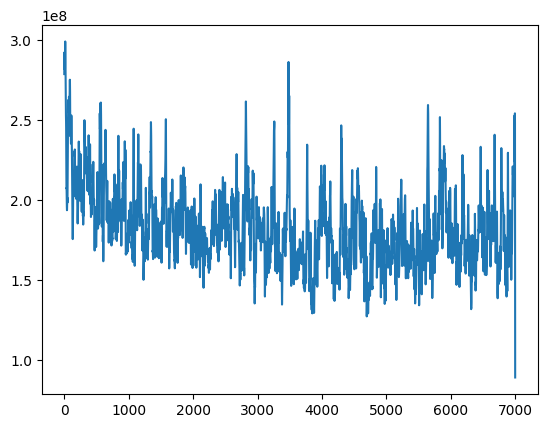

In [6]:
#plot variance for each point - this only displays the graph found in the presentation if SAMPLE_LENGTH and SAMPLE_SITE are set to 9000
pd.Series(test_variance_data).plot.line()
#plt.savefig('test_variance.png')
plt.show()

## wfdb isolation of beats

In [6]:
#identify location of each R peak
train_peaks = []
test_peaks = []
for i in range(len(X_train)):
    train_peaks.append(wfdb.processing.xqrs_detect(X_train[i], fs=300, verbose=False))

for i in range(len(X_test)):
    test_peaks.append(wfdb.processing.xqrs_detect(X_test[i], fs=300, verbose=False))

In [7]:
#identify start and stop positions of each cycle
train_lengths = []
test_lengths = []

for each in train_peaks:
    train_lengths.append(len(each))
for each in test_peaks:
    test_lengths.append(len(each))

<Axes: ylabel='Frequency'>

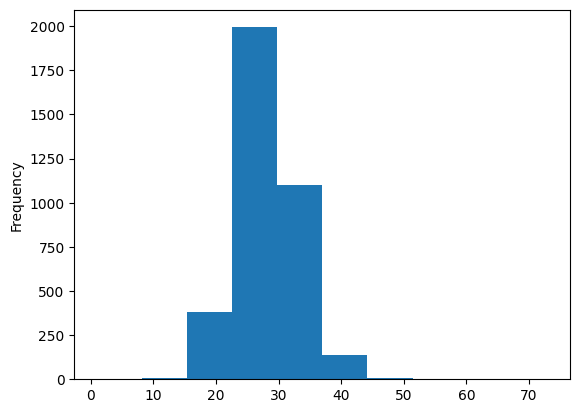

In [14]:
#distribution of train dataset 
pd.Series(train_lengths).plot.hist()

<Axes: ylabel='Frequency'>

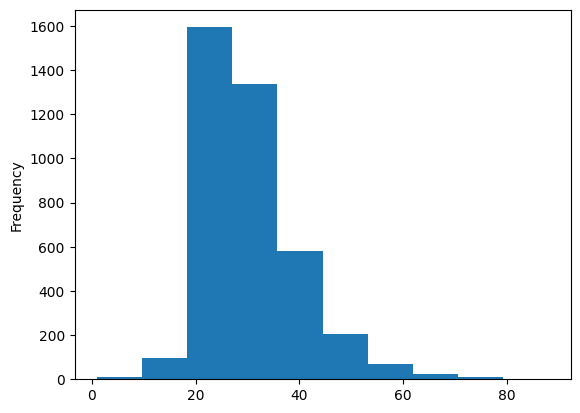

In [15]:
pd.Series(test_lengths).plot.hist()

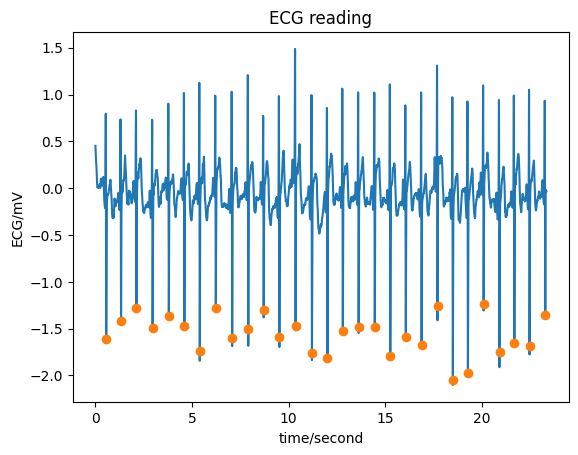

In [179]:
#this can examine any ECG read we want to look at, with annotations of the identified R-peaks
j=3405

fig = wfdb.plot_items(
    X_train[j],
    [train_peaks[j]],
    fs=300,
    sig_name=["ECG"],
    sig_units=["mV"],
    time_units="seconds",
    return_fig=True,
    ann_style="o",
    title ='ECG reading'
)

In [171]:
# calculate halfway point between each peak, use halfway points to determine start/end of each cardiac cycle, extract cycles to individual arrays
# prints number of reads dropped due to lack of peak detection and their position in the dataset
def Beat_mixer(ECG, peak_data, Y_data):
    beats = []
    Y_beats = []
    count = 0
    for i in range(len(ECG)):
        if (len(peak_data[i]) > 2):
            for j in range(len(peak_data)-2):
                beat = 0
                try:
                    start = (peak_data[i][j] + peak_data[i][j+1])/2
                    stop = (peak_data[i][j+1] + peak_data[i][j+2])/2
                    beat = ECG[i][int(start):int(stop)]
                except IndexError:
                    continue
                beats.append(beat)
                Y_beats.append(Y_data[i])
        else:
            count = count + 1
            print(i)
    print(count)
    return beats, Y_beats


train_beats, Y_train_beats = Beat_mixer(X_train, train_peaks, Y_train)
test_beats, Y_test_beats = Beat_mixer(X_test, test_peaks, Y_test)


print("X_train: " + str(len(train_beats)))
print("Y_train: " + str(len(Y_train_beats)))
print("X_test: " + str(len(test_beats)))
print("Y_test: " + str(len(Y_test_beats)))

3401
1
1510
1
X_train: 94209
Y_train: 94209
X_test: 112612
Y_test: 112612


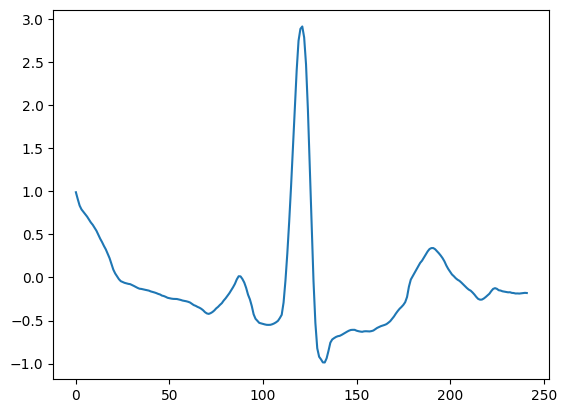

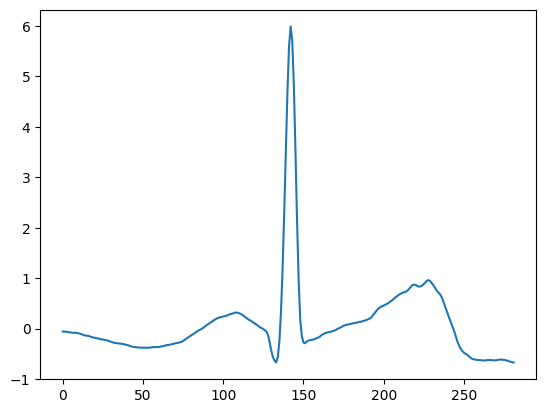

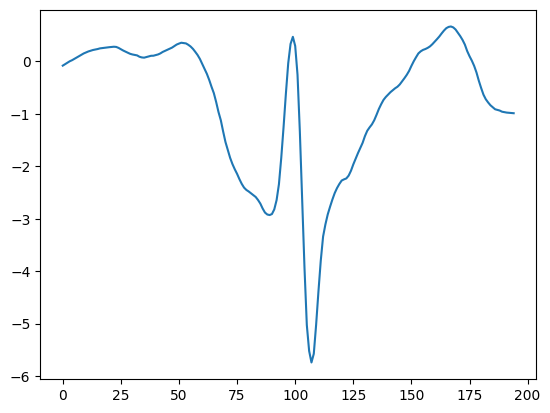

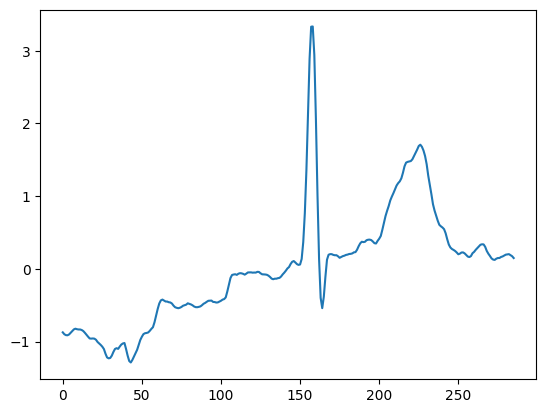

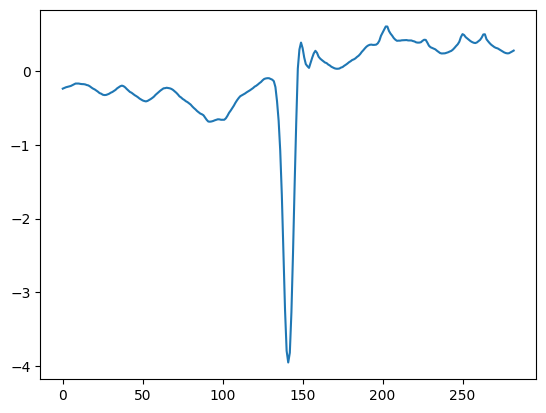

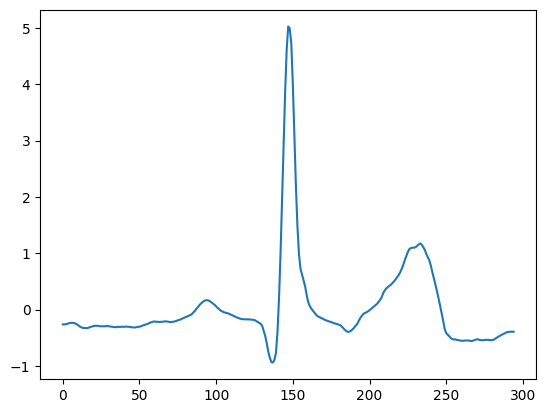

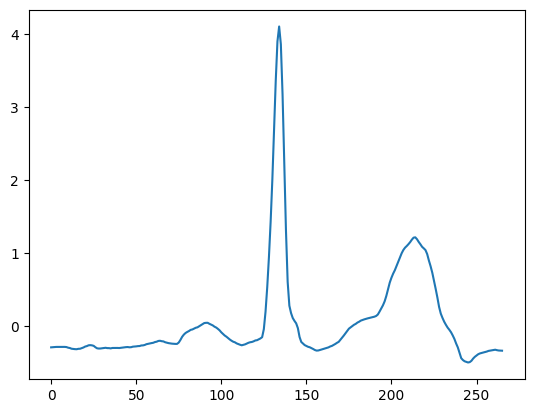

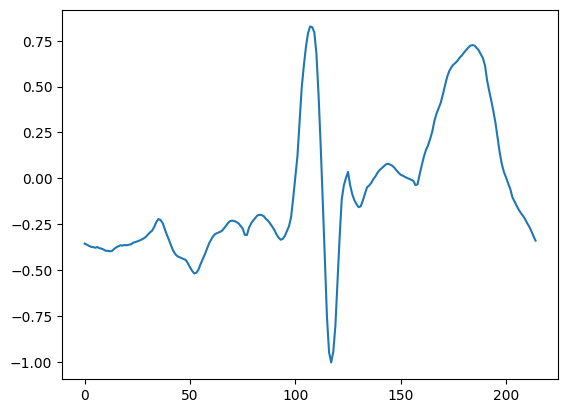

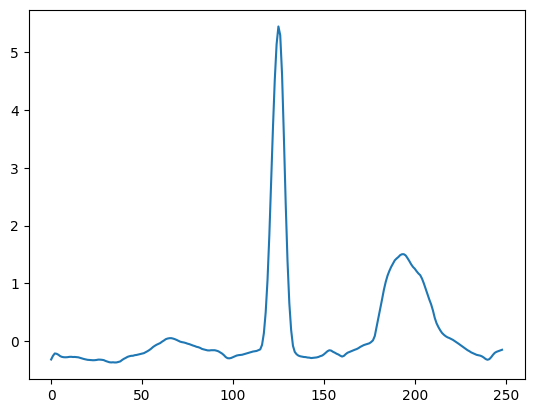

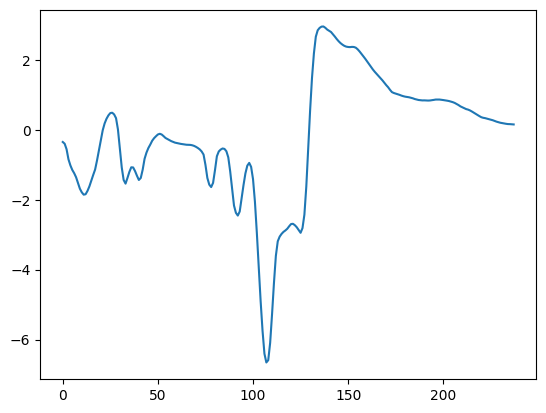

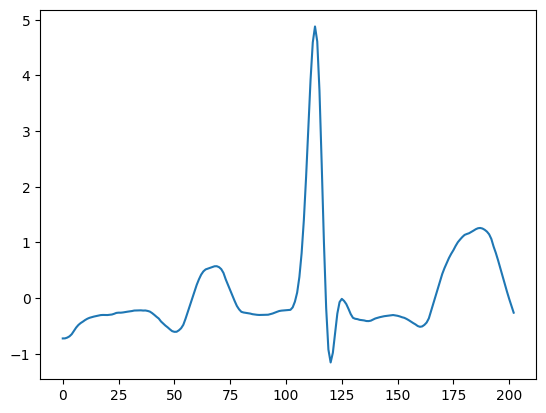

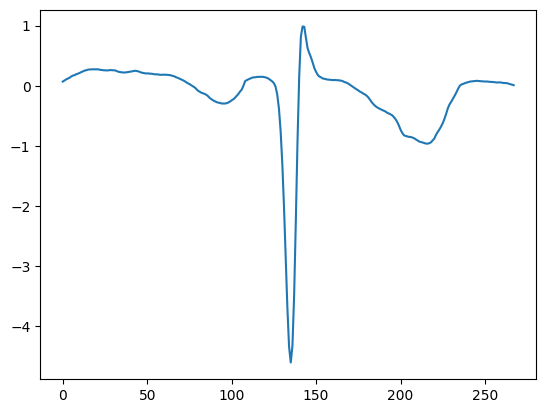

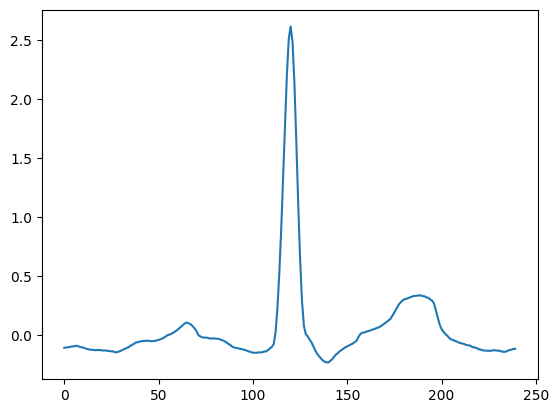

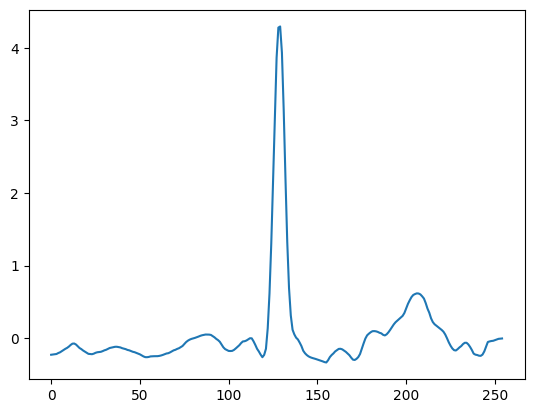

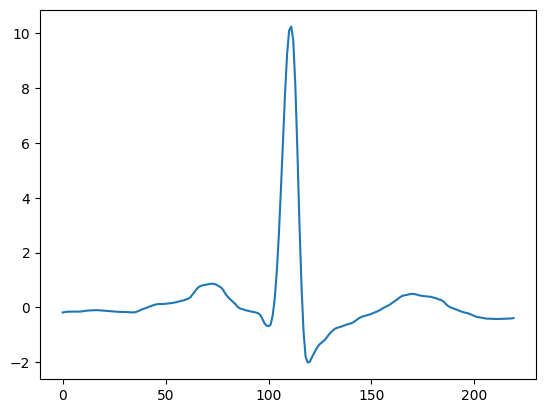

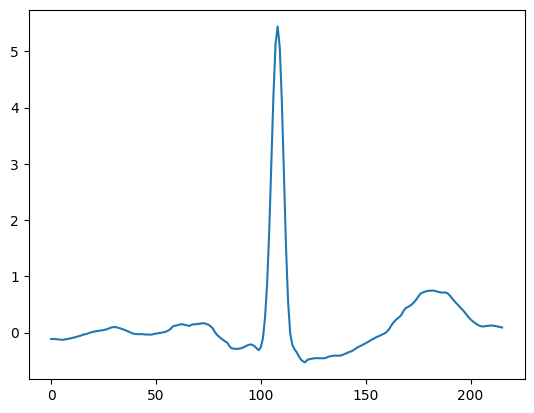

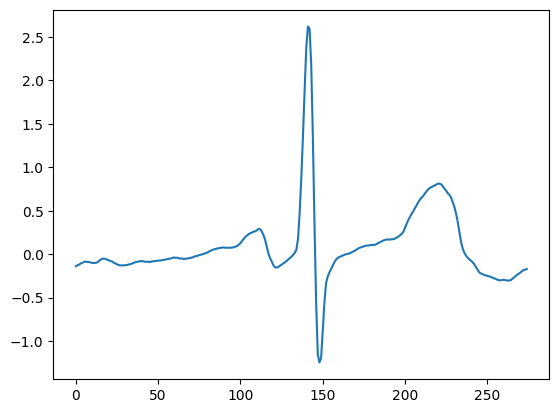

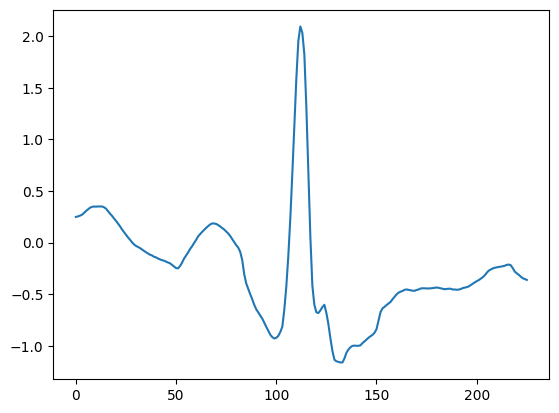

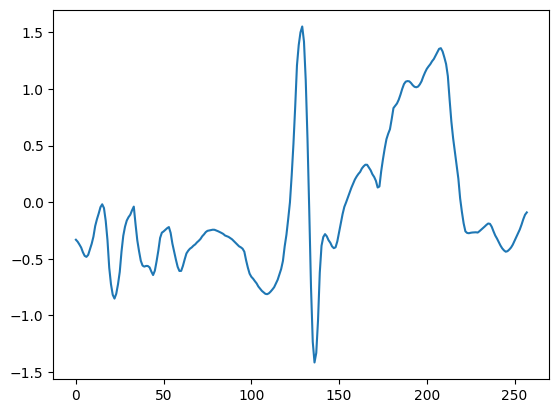

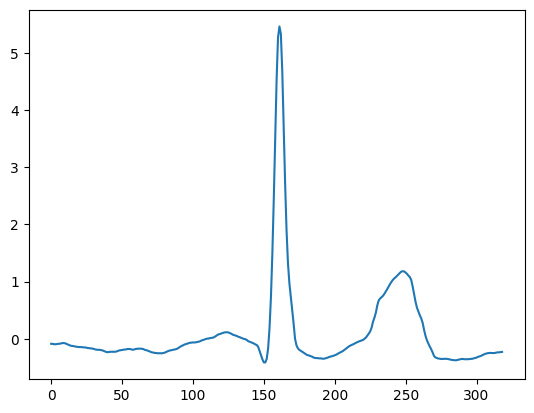

In [15]:
#examine our single cardiac cycles
for i in range(0,5000,250):
    pd.Series(train_beats[i]).plot.line()
    plt.show()

min: 63


<Axes: ylabel='Frequency'>

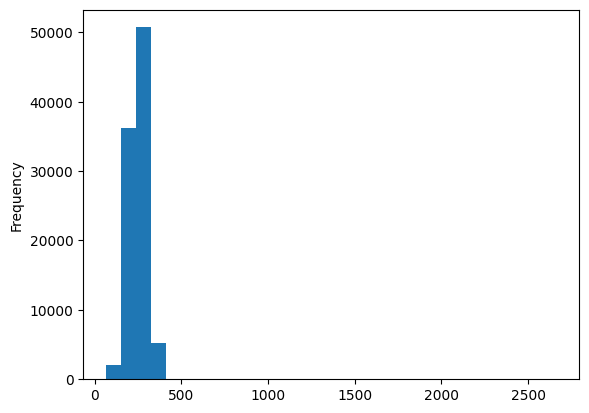

In [21]:
#observe lengths of each extracted beat
lengths = []

for i in range(len(train_beats)):
    lengths.append(len(train_beats[i]))
series = pd.Series(lengths)
print('min: ' + str(series.min()))
series.plot.hist(bins = 30)

In [175]:
# standardize lengths of each beat to 208 data points. drop any cycles shorter than that 
SAMPLE_LENGTH = 208


def Beat_processor(X,Y):
    assert len(X) == len(Y), "starting lengths of different lengths"
    X_trimmed = []
    Y_trimmed = []
    count = 0
    for i in range(len(X)):
        # we are discarding all beats above 400 measurement
        if ((len(X[i]) <= 400) & (len(X[i]) >= SAMPLE_LENGTH)):
            # take the middle 200 of each beat
            length = len(X[i])
            start = int(length/2 - SAMPLE_LENGTH/2)
            stop = int(length/2 + SAMPLE_LENGTH/2)
            standardized_beat = X[i][start:stop]
            X_trimmed.append(standardized_beat)
            Y_trimmed.append(Y[i])
        if (len(X[i]) > 400):
            count += 1
    assert len(X_trimmed) == len(Y_trimmed), "final values of different lengths"
    print(count, 'cycles omitted')
    return X_trimmed, Y_trimmed

print('Train dataset:')
X_train_beats_trimmed, Y_train_beats_trimmed = Beat_processor(train_beats, Y_train_beats)
print('Test dataset:')
X_test_beats_trimmed, Y_test_beats_trimmed = Beat_processor(test_beats, Y_test_beats)

Train dataset:
57 cycles omitted
Test dataset:
1109 cycles omitted


In [10]:
#equalize our test datset to have the same number of anomalous and normal samples.

def DF_equalizer(X,Y):
    count = 0
    new_X = []
    new_Y = []
    for i in range(len(X)):
        abnormal_cycles = pd.Series(Y_test_beats_trimmed).value_counts()[0]
        if count == abnormal_cycles:
            if (Y[i] == 0):
                new_X.append(X[i])
                new_Y.append(Y[i])
        else:
            if (Y[i] == 1):
                count += 1
            new_X.append(X[i])
            new_Y.append(Y[i])
    return new_X, new_Y

X_test_beats_trimmed, Y_test_beats_trimmed = DF_equalizer(X_test_beats_trimmed, Y_test_beats_trimmed)

In [13]:
#split train test data
X_val_split, X_test_split, y_val_split, y_test_split = train_test_split(X_test_beats_trimmed, Y_test_beats_trimmed, test_size=0.5, random_state=42)

## PCA & DWT

In [66]:
#performs PCA and DWT on datasets provided.

def PCA_wrapper(train, val, test, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(val)
    test_pca = pca.transform(test)
    return train_pca, val_pca, test_pca


def DWT_wrapper(data, level, wavelet = 'bior1.1'):
    data_dwt = []
    for i in range(len(data)):
        coeffs = wavedec(data[i], wavelet = 'bior1.1', level = level)
        data_dwt.append(coeffs[1])
    return data_dwt

## Isolation Forest 

In [16]:
def IF_map(num):
    if (num == -1):
        return 1
    elif (num == 1):
        return 0
    else:
        print('error!')


def IF_wrapper(X_train, X_test, Y_test, verbose = True):
    clf = IsolationForest(random_state=42, n_estimators=1000).fit(X_train[:50])
    Y_test_pred = list(map(IF_map, clf.predict(X_test)))
    cm = confusion_matrix(Y_test, Y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])

    if verbose is True:
        print_stats(Y_test_pred, Y_test)
        disp.plot()
        plt.show()
    return Y_test_pred



IF_X_train = X_train_beats_trimmed
IF_X_test = X_test_split
IF_X_val = X_val_split
IF_Y_train = Y_train_beats_trimmed
IF_Y_test = y_test_split
IF_Y_val = y_val_split

### IF PCA

2
Accuracy = 0.51747543308682
Precision = 0.5120287041938709
Recall = 0.8761952692501258


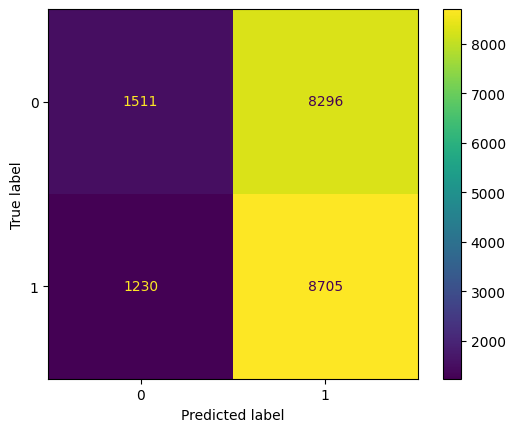

6
Accuracy = 0.5080538952487084
Precision = 0.5075312394461331
Recall = 0.7563160543532964


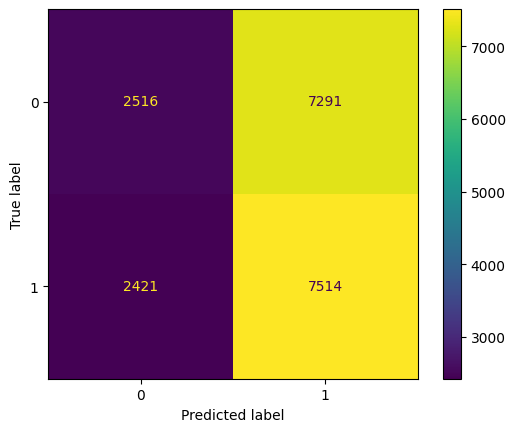

10
Accuracy = 0.5480701043460642
Precision = 0.5399605522682446
Recall = 0.6888777050830398


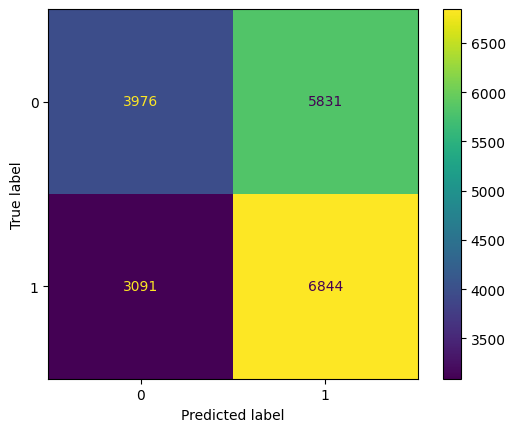

14
Accuracy = 0.5911761726268868
Precision = 0.5915880503144654
Recall = 0.6059386009058882


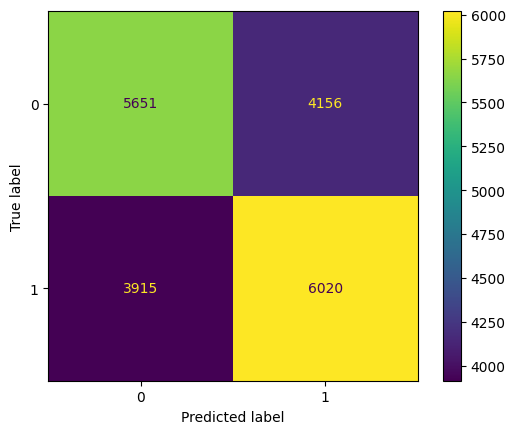

18
Accuracy = 0.6155911255191977
Precision = 0.6376760563380282
Recall = 0.546854554604932


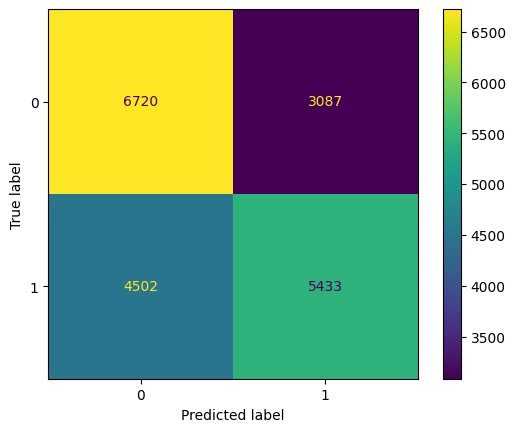

22
Accuracy = 0.6359538040725357
Precision = 0.6997093023255814
Recall = 0.4845495722194263


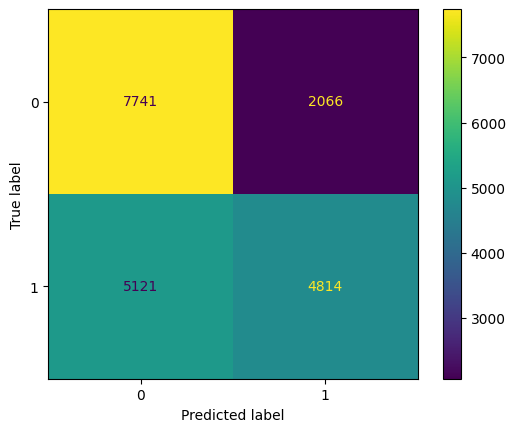

26
Accuracy = 0.6388410495390537
Precision = 0.7324714072600697
Recall = 0.4447911424257675


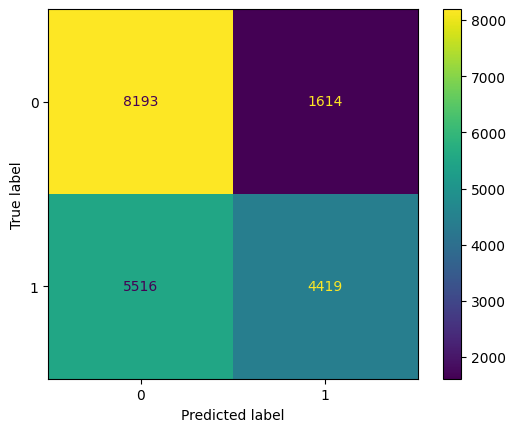

In [17]:
#IF_PCA gridsearch
IF_pca_prec = []
IF_pca_rec = []
IF_pca_acc = []

for i in range(2,27,4):
    print(i)
    X_train_pca, X_val_pca, X_test_pca = PCA_wrapper(X_train_beats_trimmed, IF_X_val, IF_X_test, i)
    Y_test_pred = IF_wrapper(X_train_pca, X_val_pca, IF_Y_val)
    IF_pca_prec.append(recall_score(Y_test_pred,IF_Y_val))
    IF_pca_rec.append(precision_score(Y_test_pred,IF_Y_val))
    IF_pca_acc.append(accuracy_score(Y_test_pred,IF_Y_val))

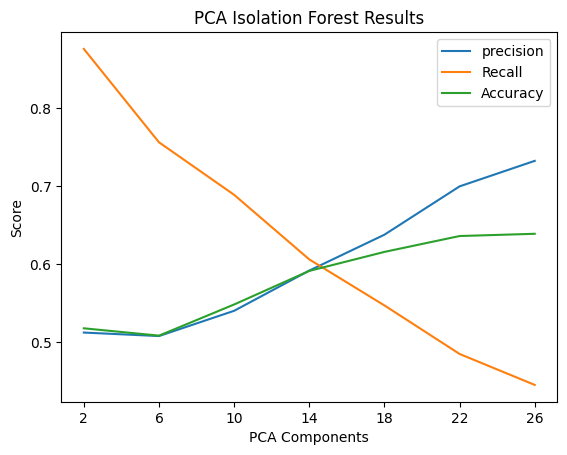

In [18]:
#plot search results
x = range(2,27,4)
plt.plot(x, IF_pca_prec, label='precision')
plt.plot(x, IF_pca_rec, label='Recall')
plt.plot(x, IF_pca_acc, label='Accuracy')

# Adding labels and title
plt.xlabel('PCA Components')
plt.ylabel('Score')
plt.xticks(range(2,27,4))
plt.title('PCA Isolation Forest Results')

# Adding legend
plt.legend()

# Display the plot
plt.show()

### IF DWT

1
Accuracy = 0.49741667510890486
Precision = 0.5207667731629393
Recall = 0.016406643180674384


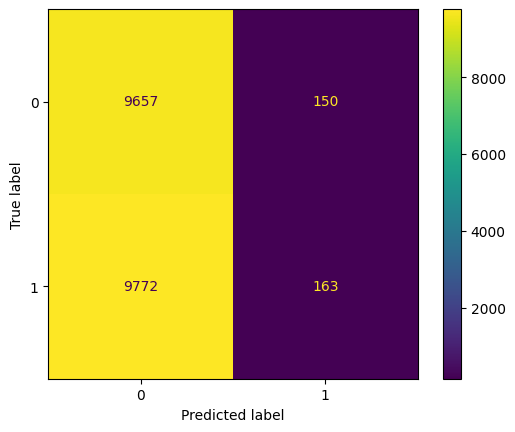

2


F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Accuracy = 0.49832843683517375
Precision = 0.5233785822021116
Recall = 0.03492702566683442


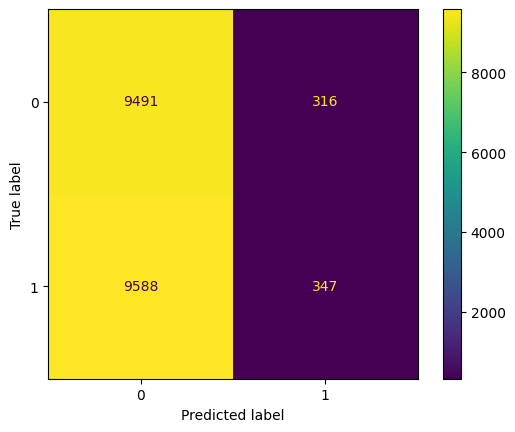

3


F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Accuracy = 0.5020261371694864
Precision = 0.5380116959064327
Recall = 0.07408152994464016


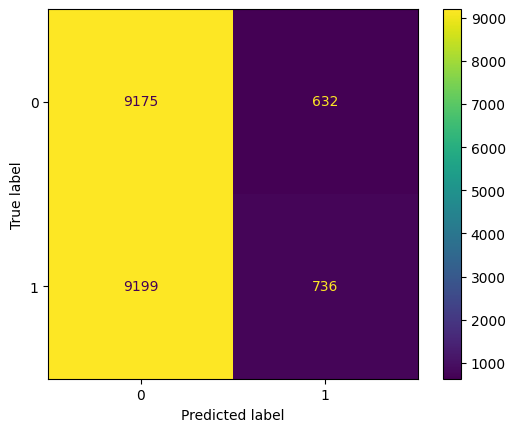

4


F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Accuracy = 0.5070914800932023
Precision = 0.5315398886827458
Recall = 0.17302466029189734


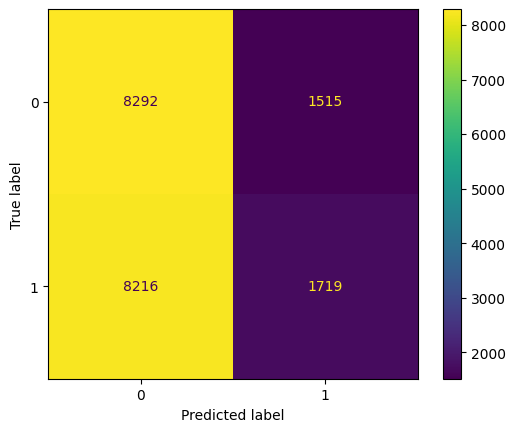

5


F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Accuracy = 0.53495086617364
Precision = 0.5462576687116565
Recall = 0.4481127327629592


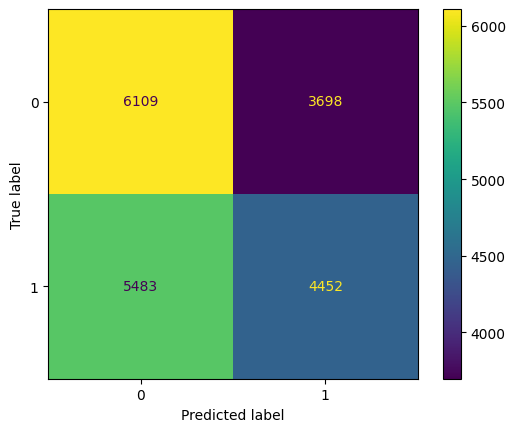

6


F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Accuracy = 0.5569851078918042
Precision = 0.5632783395423098
Recall = 0.5326623049823855


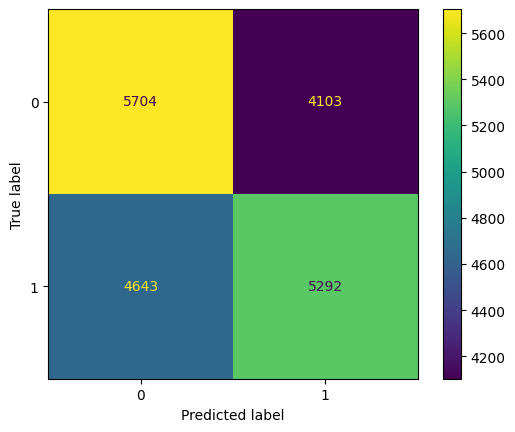

7


F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Accuracy = 0.5446256711579374
Precision = 0.5345622119815668
Recall = 0.7355812783090085


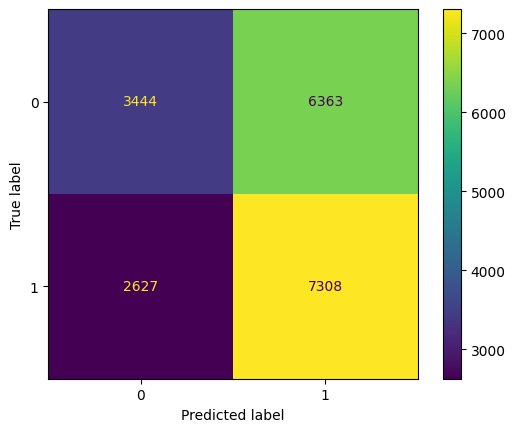

In [19]:
#DWT hyperparameter search
IF_dwt_prec = []
IF_dwt_rec = []
IF_dwt_acc = []

for i in range(1,8):
    print(i)
    X_train_dwt = DWT_wrapper(X_train_beats_trimmed, i)
    X_val_dwt = DWT_wrapper(IF_X_val, i)
    X_test_dwt = DWT_wrapper(IF_X_test, i)
    Y_test_pred = IF_wrapper(X_train_dwt, X_val_dwt, IF_Y_val)
    IF_dwt_prec.append(recall_score(Y_test_pred, IF_Y_val))
    IF_dwt_rec.append(precision_score(Y_test_pred, IF_Y_val))
    IF_dwt_acc.append(accuracy_score(Y_test_pred, IF_Y_val))

In [15]:
#DWT search over every wavelet type and levels 1-7 (takes a long time to run)
max = 0
specs = 0
for h in pywt.wavelist():
    for i in range(1,8):
        X_train_dwt = DWT_wrapper(data=X_train_beats_trimmed, level=i, wavelet=h)
        X_val_dwt = DWT_wrapper(IF_X_val, i, wavelet=h)
        X_test_dwt = DWT_wrapper(IF_X_test, i, wavelet=h)
        Y_test_pred = IF_wrapper(X_train_dwt, X_val_dwt, IF_Y_val, verbose = False)
        if precision_score(Y_test_pred, IF_Y_val) > 0.5 and recall_score(Y_test_pred, IF_Y_val) > 0.5:
            overall = recall_score(Y_test_pred, IF_Y_val) + precision_score(Y_test_pred, IF_Y_val) + accuracy_score(Y_test_pred, IF_Y_val)
            if overall > max:
                max = overall
                specs = (h, i)
print(max)
print(specs)

F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
F:\Anaconda\envs\jupyterlablsp\lib\site-packages\pywt\_multilevel.py:43: UserWar

1.8147691614485126
('bior1.1', 7)


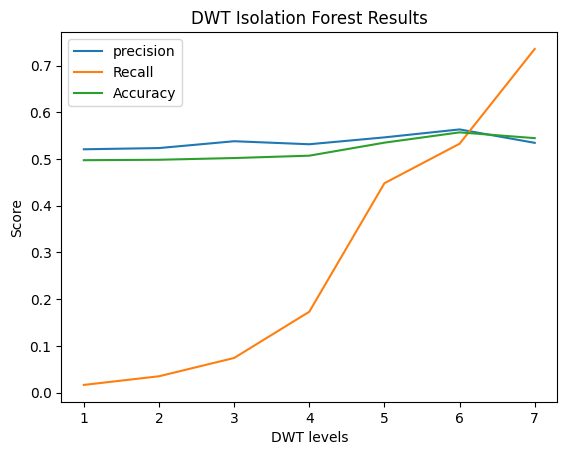

In [20]:
# Plotting the lines
x = range(1, 8)
plt.plot(x, IF_dwt_prec, label='precision')
plt.plot(x, IF_dwt_rec, label='Recall')
plt.plot(x, IF_dwt_acc, label='Accuracy')

# Adding labels and title
plt.xlabel('DWT levels')
plt.ylabel('Score')
plt.title('DWT Isolation Forest Results')

# Adding legend
plt.legend()

# Display the plot
plt.show()

### IF final model - PCA with n_components set to 14

Accuracy = 0.5843886131091075
Precision = 0.5790720631786772
Recall = 0.5981441827266238


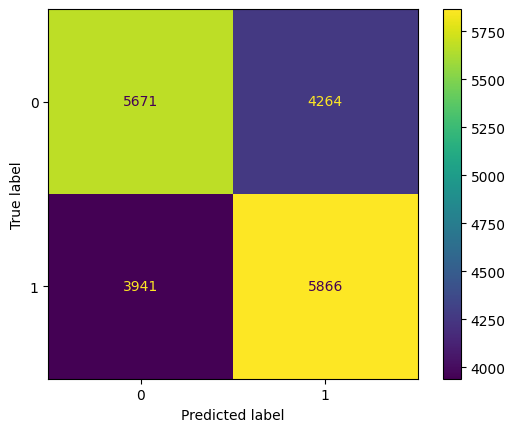

In [135]:
IF_train_start = time.time()
X_train_pca, X_val_pca, X_test_pca = PCA_wrapper(X_train_beats_trimmed, IF_X_val, IF_X_test, 14)
clf = IsolationForest(random_state=42, n_estimators=1000).fit(X_train_pca[:50])
IF_train_time = time.time() - IF_train_start

IF_test_start = time.time()
Y_test_pred_raw = clf.predict(X_test_pca)
IF_test_time = time.time() - IF_test_start

Y_test_pred = list(map(IF_map, Y_test_pred_raw))

cm = confusion_matrix(IF_Y_test, Y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])

print_stats(Y_test_pred, IF_Y_test)
disp.plot()
plt.show()

# GMM time

In [67]:
def GMM_wrapper(X_train, X_test, y_test, init_params = 'k-means++', verbose = True):
    gmm = GaussianMixture(n_components=2, random_state=42, init_params=init_params, covariance_type='full').fit(X_train)
    Y_test_pred = gmm.predict(X_test)
    cm = confusion_matrix(y_test, Y_test_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
    if verbose is True:
        disp.plot()
        plt.show()
        print_stats(Y_test_pred, y_test)
    return Y_test_pred

GMM_X_train = X_train_beats_trimmed
GMM_X_val = X_val_split
GMM_X_test = X_test_split
GMM_Y_train = Y_train_beats_trimmed
GMM_Y_val = y_val_split
GMM_Y_test = y_test_split

2


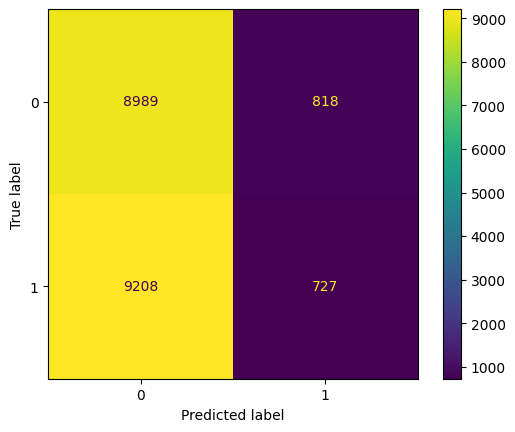

Accuracy = 0.4921487184682403
Precision = 0.47055016181229775
Recall = 0.07317564167086059
6


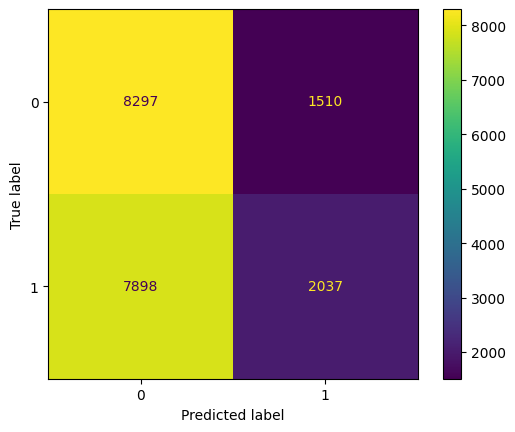

Accuracy = 0.5234525377368048
Precision = 0.574288130814773
Recall = 0.2050327126321087
10


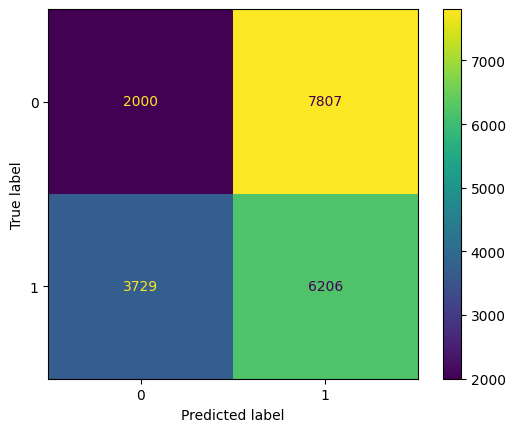

Accuracy = 0.41566204032012966
Precision = 0.4428744737029901
Recall = 0.6246602918973326
14


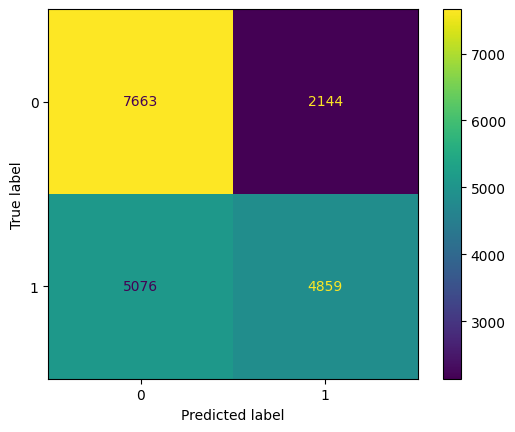

Accuracy = 0.6342822409077095
Precision = 0.693845494787948
Recall = 0.4890790135883241
18


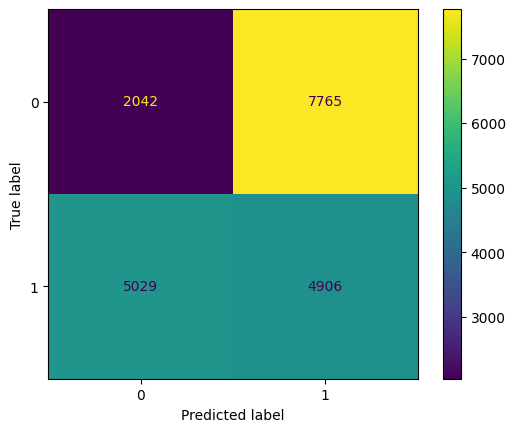

Accuracy = 0.3519400263397832
Precision = 0.3871833320179938
Recall = 0.49380976346250627
22


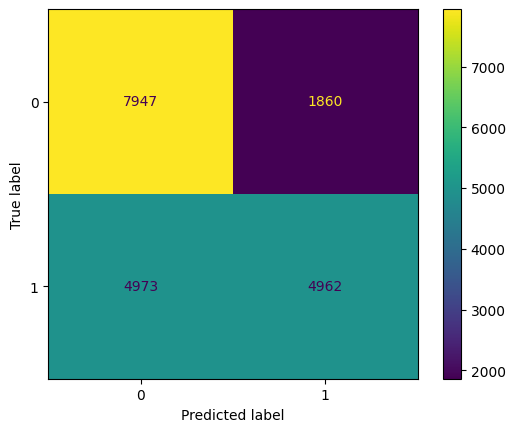

Accuracy = 0.6538851180224902
Precision = 0.7273526824978013
Recall = 0.49944640161046805
26


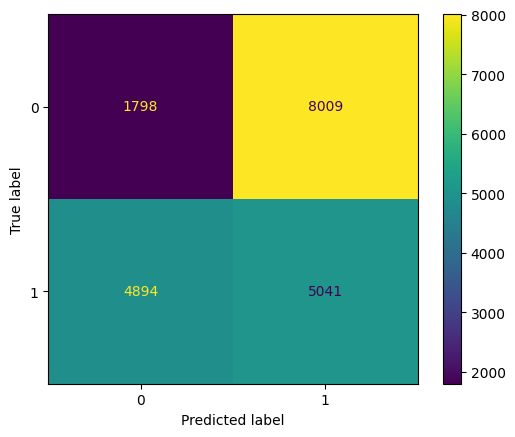

Accuracy = 0.34641880255293284
Precision = 0.3862835249042146
Recall = 0.5073980875691998


In [68]:
#GMM_PCA gridsearch
GMM_pca_prec = []
GMM_pca_rec = []
GMM_pca_acc = []

for i in range(2,27,4):
    print(i)
    X_train_pca, X_val_pca, X_test_pca = PCA_wrapper(GMM_X_train, GMM_X_val, GMM_X_test, i)
    Y_test_pred = GMM_wrapper(X_train_pca, X_val_pca, GMM_Y_val)
    GMM_pca_prec.append(recall_score(Y_test_pred, GMM_Y_val))
    GMM_pca_rec.append(precision_score(Y_test_pred, GMM_Y_val))
    GMM_pca_acc.append(accuracy_score(Y_test_pred, GMM_Y_val))

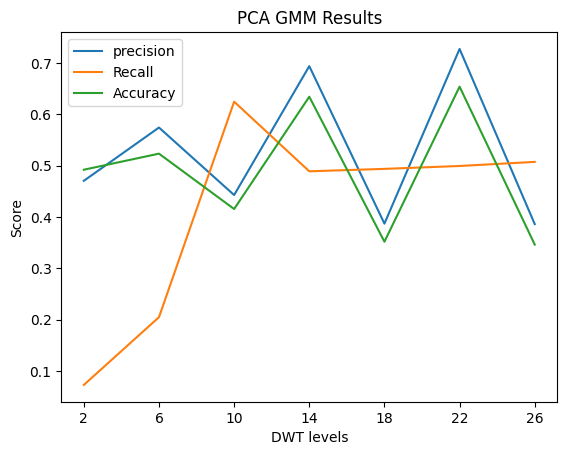

In [69]:
# Plotting the lines
x = range(2, 27, 4)
plt.plot(x, GMM_pca_prec, label='precision')
plt.plot(x, GMM_pca_rec, label='Recall')
plt.plot(x, GMM_pca_acc, label='Accuracy')

# Adding labels and title
plt.xlabel('DWT levels')
plt.ylabel('Score')
plt.xticks(range(2, 27, 4))
plt.title('PCA GMM Results')

# Adding legend
plt.legend()

# Display the plot
plt.show()

### GMM DWT

1


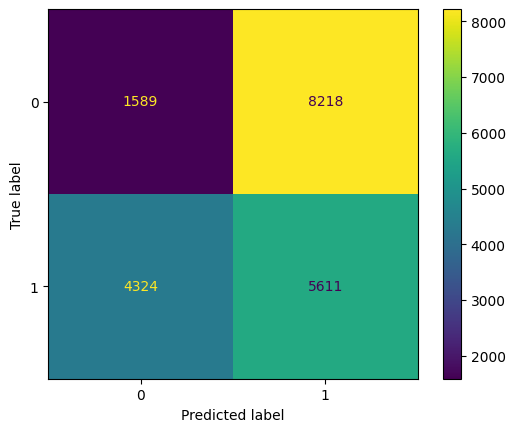

Accuracy = 0.36470469050754734
Precision = 0.4057415575963555
Recall = 0.564771011575239
2


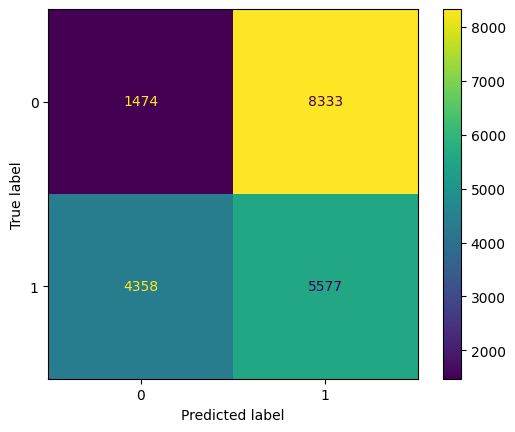

Accuracy = 0.3571573295512106
Precision = 0.4009345794392523
Recall = 0.5613487669854051
3


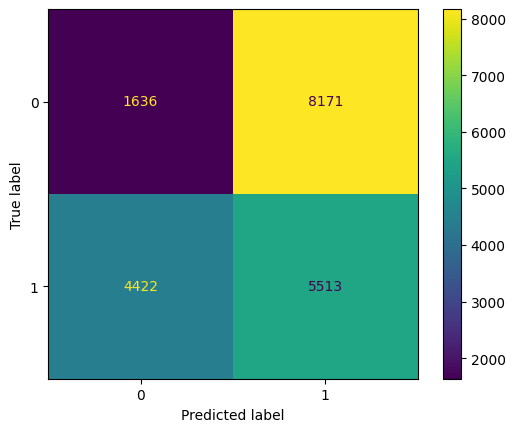

Accuracy = 0.36212136561645225
Precision = 0.40287927506577026
Recall = 0.554906894816306
4


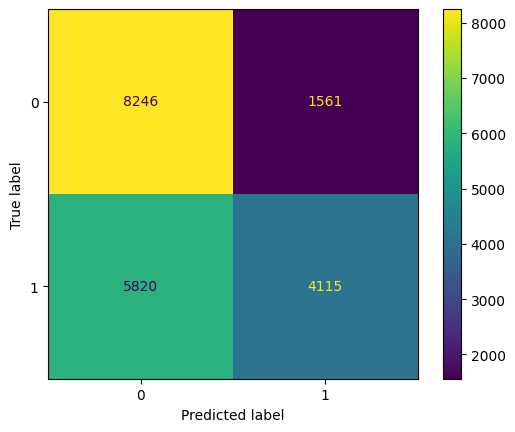

Accuracy = 0.6261270388005268
Precision = 0.7249823819591261
Recall = 0.4141922496225465
5


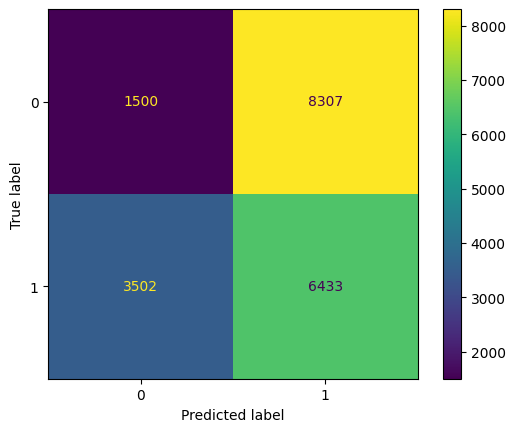

Accuracy = 0.4018336541383852
Precision = 0.4364314789687924
Recall = 0.6475088072471062
6


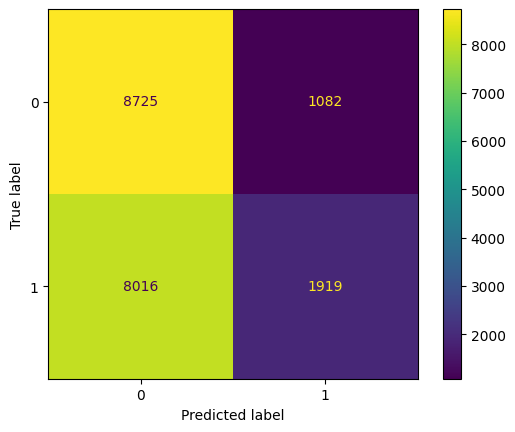

Accuracy = 0.5391551008003241
Precision = 0.6394535154948351
Recall = 0.19315551082033217
7


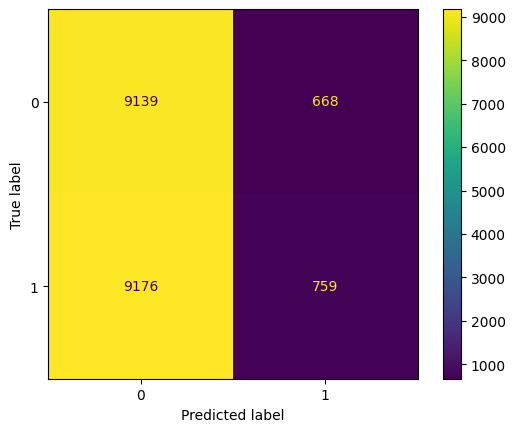

Accuracy = 0.5013676425894033
Precision = 0.5318850735809391
Recall = 0.07639657775541017


In [148]:
GMM_dwt_prec = []
GMM_dwt_rec = []
GMM_dwt_acc = []

for i in range(1,8):
    print(i)
    X_train_dwt = DWT_wrapper(GMM_X_train, i)
    X_val_dwt = DWT_wrapper(GMM_X_val, i)
    X_test_dwt = DWT_wrapper(GMM_X_test, i)
    Y_test_pred = GMM_wrapper(X_train_dwt, X_val_dwt, GMM_Y_val)
    GMM_dwt_prec.append(recall_score(Y_test_pred, GMM_Y_val))
    GMM_dwt_rec.append(precision_score(Y_test_pred, GMM_Y_val))
    GMM_dwt_acc.append(accuracy_score(Y_test_pred, GMM_Y_val))

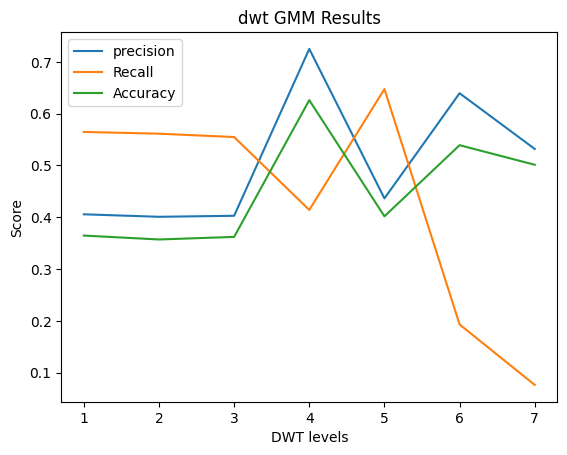

In [157]:
# Plotting the lines
x = range(1,8)
plt.plot(x, GMM_dwt_prec, label='precision')
plt.plot(x, GMM_dwt_rec, label='Recall')
plt.plot(x, GMM_dwt_acc, label='Accuracy')

# Adding labels and title
plt.xlabel('DWT levels')
plt.ylabel('Score')
plt.xticks(range(1,8))
plt.title('dwt GMM Results')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [150]:
#DWT hyperparameter search
max_gmm = 0
specs_gmm = 0
for h in pywt.wavelist():
    for i in range(1,8):
        X_train_dwt = DWT_wrapper(data=X_train_beats_trimmed, level=i, wavelet =h)
        X_val_dwt = DWT_wrapper(GMM_X_val, i, wavelet = h)
        X_test_dwt = DWT_wrapper(GMM_X_test, i, wavelet = h)
        Y_test_pred = GMM_wrapper(X_train_dwt, X_val_dwt, GMM_Y_val, verbose = False)
        if precision_score(Y_test_pred, GMM_Y_val) > 0.25 and recall_score(Y_test_pred, GMM_Y_val) > 0.25:
            overall = recall_score(Y_test_pred, GMM_Y_val) + precision_score(Y_test_pred, GMM_Y_val) + accuracy_score(Y_test_pred, GMM_Y_val)
            if overall > max_gmm:
                max_gmm = overall
                specs_gmm = (h, i)
print(max_gmm)
print(specs_gmm)

1.7653016703821995
('bior1.1', 4)


### GMM Final model selection

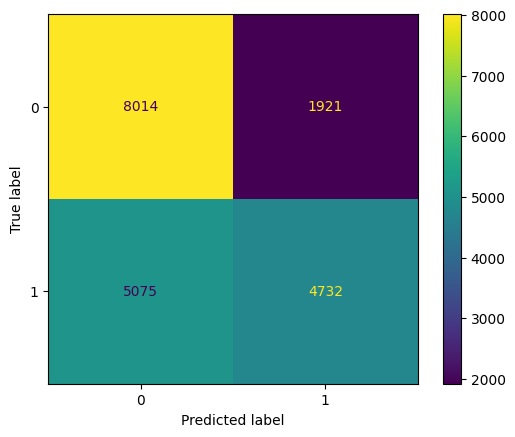

Accuracy = 0.6456286090568332
Precision = 0.7112580790620773
Recall = 0.4825124910778016


In [163]:
GMM_train_start = time.time()
X_train_pca, X_val_pca, X_test_pca = PCA_wrapper(X_train_beats_trimmed, GMM_X_val, GMM_X_test, 22)
gmm = GaussianMixture(n_components=2, random_state=42, init_params='k-means++').fit(X_train_pca)
GMM_train_time = time.time() - GMM_train_start

GMM_test_start = time.time()
Y_test_pred = gmm.predict(X_test_pca)
GMM_test_time = time.time() - GMM_test_start

cm = confusion_matrix(GMM_Y_test, Y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
disp.plot()
plt.show()
print_stats(Y_test_pred, GMM_Y_test)

## autoencoder

In [72]:
# save data to local variables
train_data = X_train_beats_trimmed
train_labels = Y_train_beats_trimmed
test_data = X_test_beats_trimmed
test_labels = Y_test_beats_trimmed


# normalize data, convert to floats
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [75]:
class MLPAnomalyDetector(Model):
    def __init__(self):
        super(MLPAnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(int(SAMPLE_LENGTH/2), activation="relu"),
            layers.Dense(int(SAMPLE_LENGTH/4), activation="relu"),
            layers.Dense(int(SAMPLE_LENGTH/8), activation="relu"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(int(SAMPLE_LENGTH/4), activation="relu"),
            layers.Dense(int(SAMPLE_LENGTH/2), activation="relu"),
            layers.Dense(int(SAMPLE_LENGTH), activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [76]:
class BiggerAnomalyDetector(Model):
    def __init__(self):
        super(BiggerAnomalyDetector, self).__init__()
        # Define input shape
        input_shape = (SAMPLE_LENGTH,1)

        # Encoder layers
        self.encoder = tf.keras.Sequential([
            Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
            MaxPooling1D(2, padding='same'),
            Conv1D(32, 3, activation='relu', padding='same'),
            MaxPooling1D(2, padding='same'),
            Conv1D(16, 3, activation='relu', padding='same'),
            MaxPooling1D(2, padding='same'),
        ])

        # Decoder layers
        self.decoder = tf.keras.Sequential([
            Conv1D(16, 3, activation='relu', padding='same'),
            UpSampling1D(2),
            Conv1D(32, 3, activation='relu', padding='same'),
            UpSampling1D(2),
            Conv1D(64, 3, activation='relu', padding='same'),
            UpSampling1D(2),
            Conv1D(1, 3, activation='sigmoid', padding='same'),
            layers.Flatten()
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [186]:
#set NN type, optimizer and loss function
autoencoder = BiggerAnomalyDetector()

MAE = 'mae'
BCE = 'binary_crossentropy'
autoencoder.compile(optimizer='adam', loss=BCE)


In [187]:
AE_train_start = time.time()

history = autoencoder.fit(train_data, train_data,
                          epochs=30,
                          batch_size=4096,
                          validation_data=(test_data, test_data),
                          shuffle=True)

AE_train_time = time.time() - AE_train_start

Epoch 1/30
19/19 [==============================] - 19s 800ms/step - loss: 0.6873 - val_loss: 0.6843
Epoch 2/30
19/19 [==============================] - 13s 712ms/step - loss: 0.6843 - val_loss: 0.6843
Epoch 3/30
19/19 [==============================] - 13s 693ms/step - loss: 0.6842 - val_loss: 0.6843
Epoch 4/30
19/19 [==============================] - 13s 714ms/step - loss: 0.6842 - val_loss: 0.6843
Epoch 5/30
19/19 [==============================] - 13s 698ms/step - loss: 0.6842 - val_loss: 0.6842
Epoch 6/30
19/19 [==============================] - 13s 716ms/step - loss: 0.6842 - val_loss: 0.6842
Epoch 7/30
19/19 [==============================] - 13s 685ms/step - loss: 0.6842 - val_loss: 0.6842
Epoch 8/30
19/19 [==============================] - 14s 716ms/step - loss: 0.6842 - val_loss: 0.6842
Epoch 9/30
19/19 [==============================] - 13s 701ms/step - loss: 0.6842 - val_loss: 0.6842
Epoch 10/30
19/19 [==============================] - 13s 713ms/step - loss: 0.6841 - val_lo

Text(0.5, 1.0, 'CNN loss')

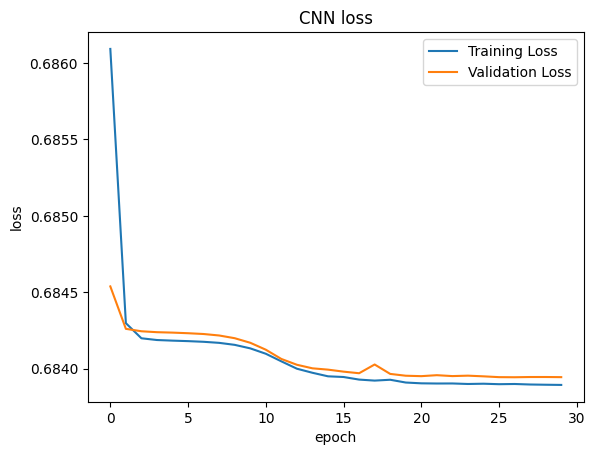

In [164]:
#loss graph
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel('loss')
plt.title('CNN loss')

In [124]:
#model summary
print("CNN model:")
autoencoder.encoder.summary()
autoencoder.decoder.summary()

CNN model:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 208, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 104, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 104, 32)           6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 52, 16)            1552      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 26, 16

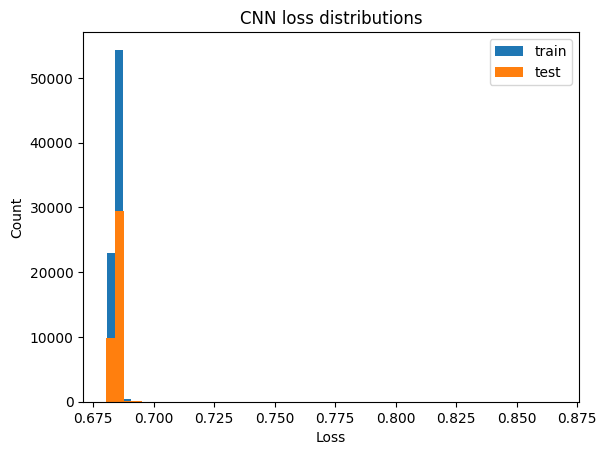

In [132]:
#dataset loss distributions
plt.hist(train_loss, bins = 50, label='train')
plt.hist(test_loss, bins = 50, label='test')
plt.title('CNN loss distributions')
plt.xlabel('Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

-------------------------
ITEM: 0


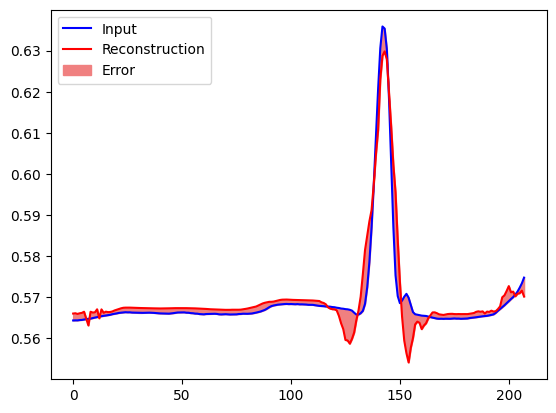

-------------------------
ITEM: 250


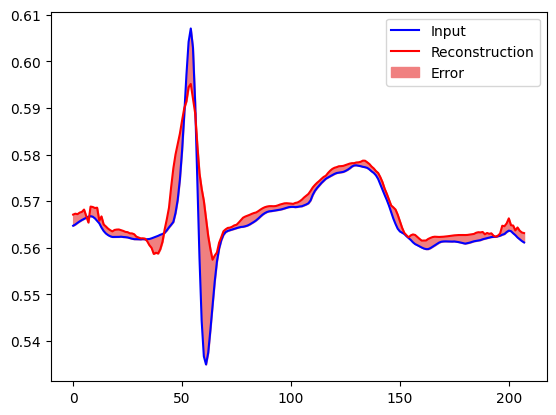

-------------------------
ITEM: 500


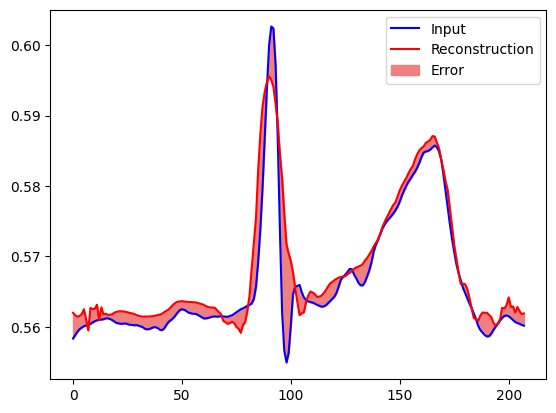

-------------------------
ITEM: 750


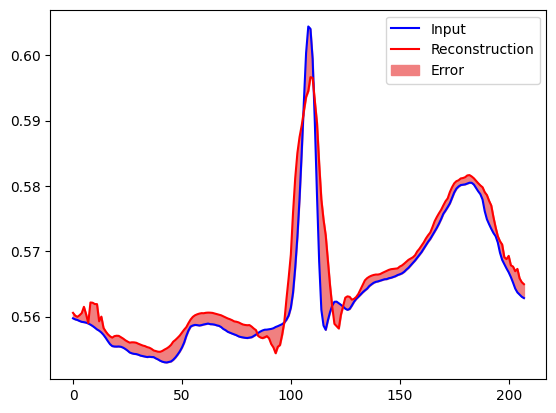

-------------------------
ITEM: 1000


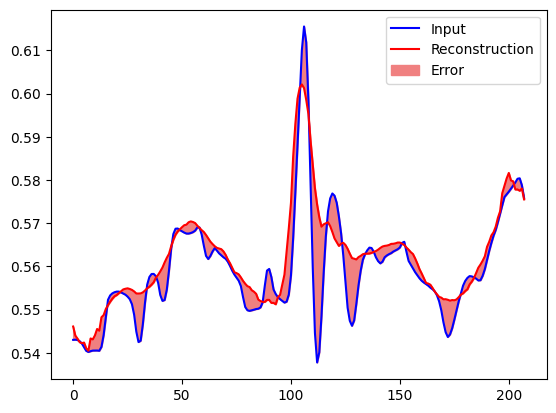

-------------------------
ITEM: 1250


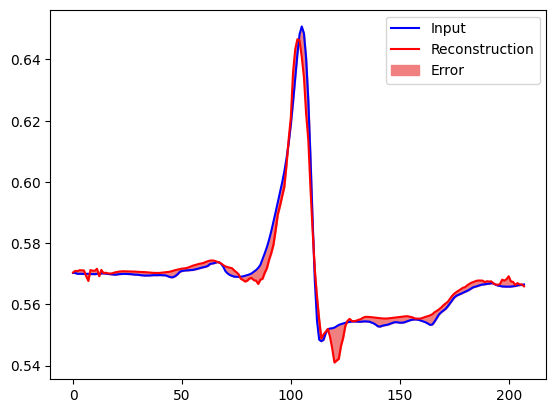

-------------------------
ITEM: 1500


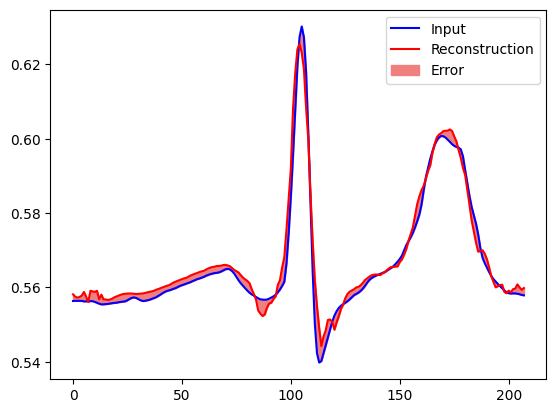

-------------------------
ITEM: 1750


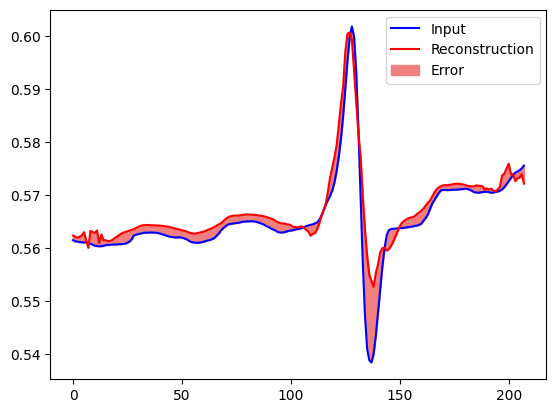

-------------------------
ITEM: 2000


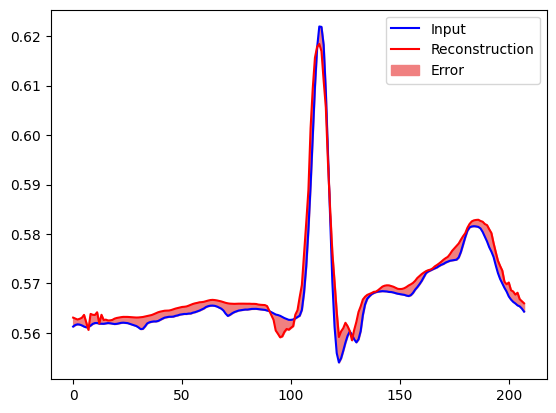

-------------------------
ITEM: 2250


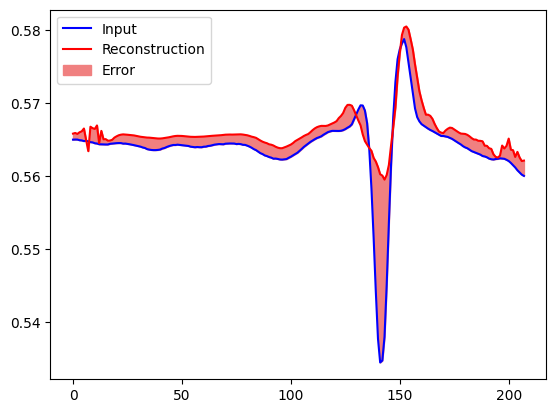

-------------------------
ITEM: 2500


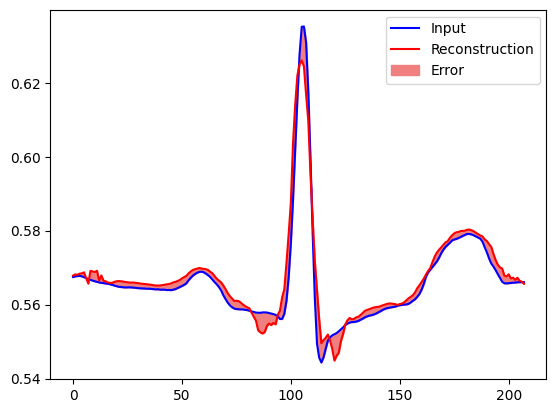

-------------------------
ITEM: 2750


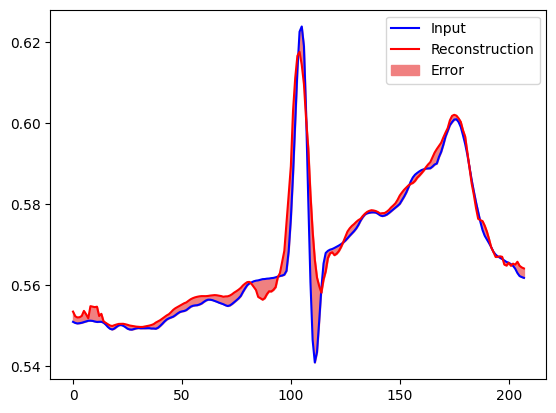

-------------------------
ITEM: 3000


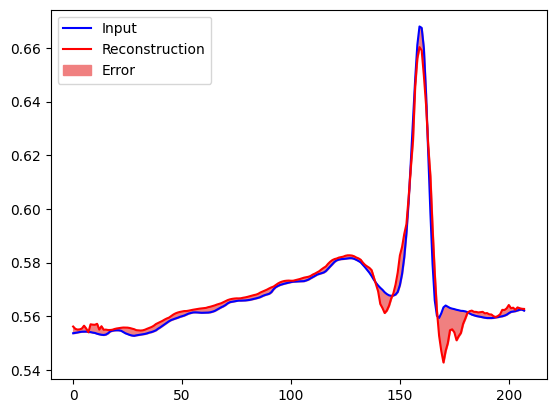

-------------------------
ITEM: 3250


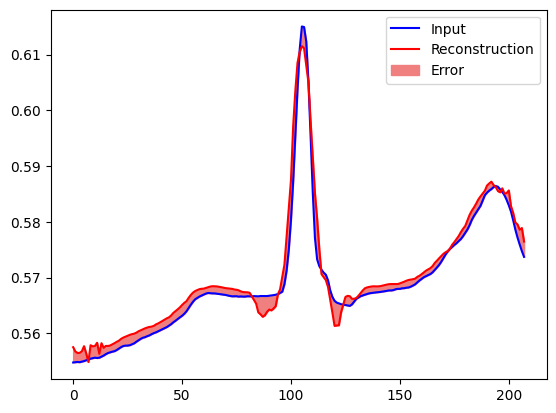

-------------------------
ITEM: 3500


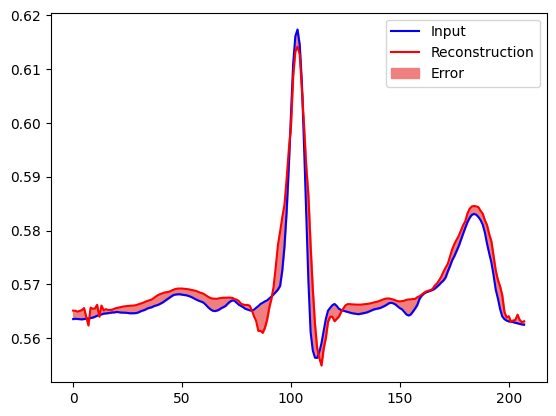

-------------------------
ITEM: 3750


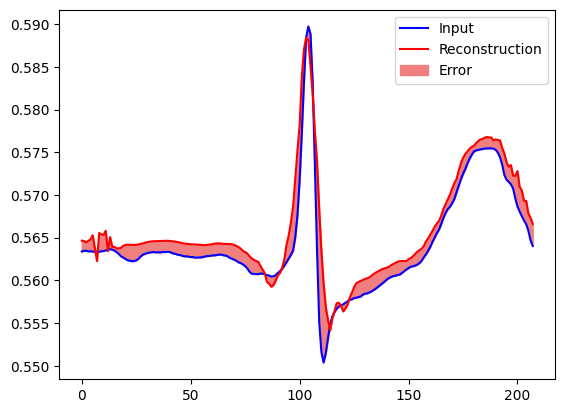

-------------------------
ITEM: 4000


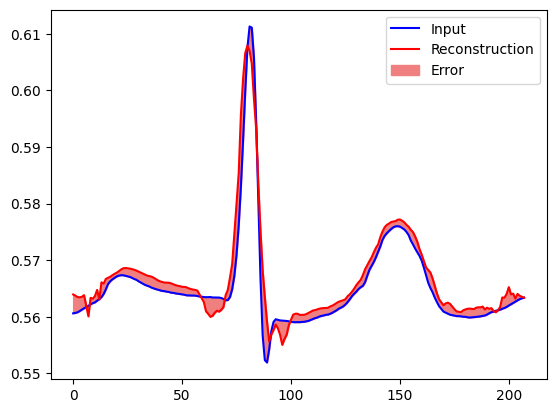

-------------------------
ITEM: 4250


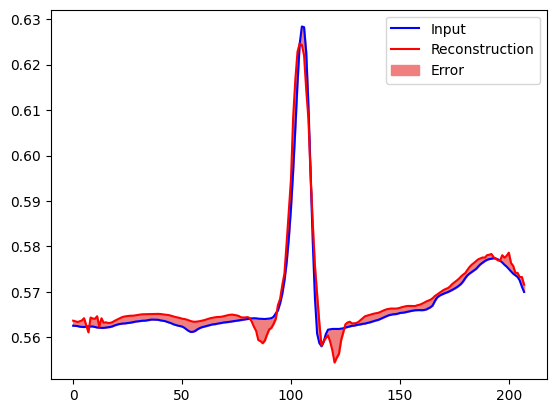

-------------------------
ITEM: 4500


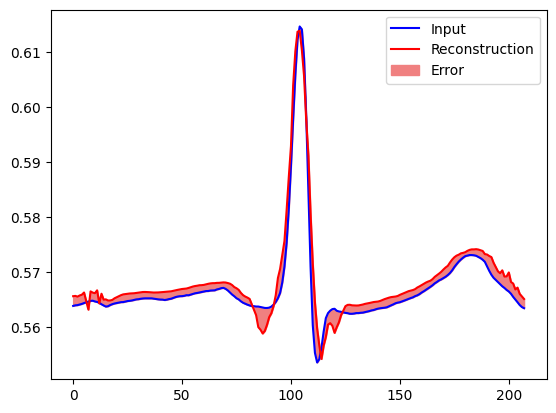

-------------------------
ITEM: 4750


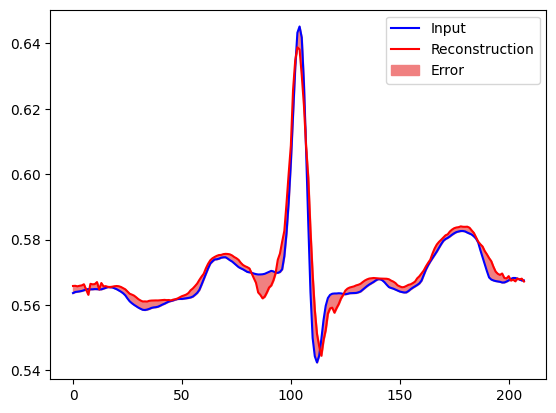

In [133]:
#reconstruction of individual samples
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for i in range(0,5000,250):
    print('-------------------------')
    print("ITEM: " + str(i))

    plt.plot(test_data[i], 'b')
    plt.plot(decoded_data[i], 'r')
    plt.fill_between(np.arange(SAMPLE_LENGTH), decoded_data[i].flatten(), test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

-------------------------
ITEM: 0


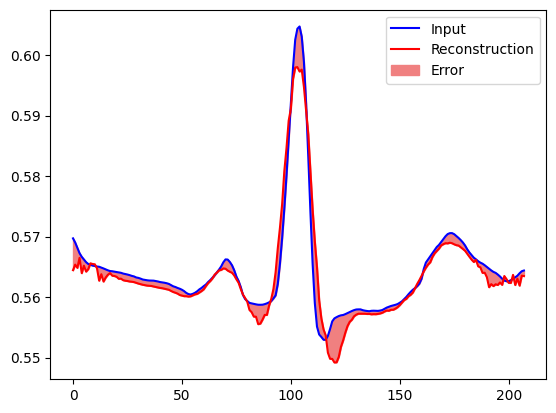

-------------------------
ITEM: 250


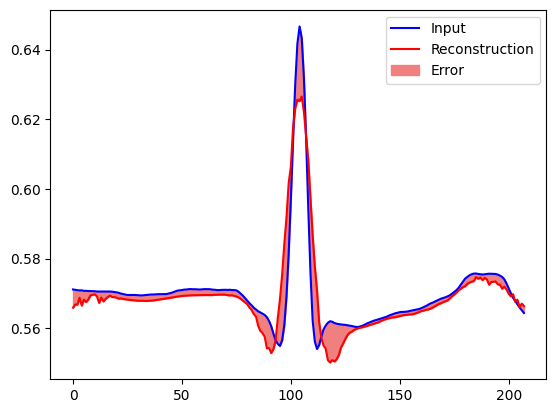

-------------------------
ITEM: 500


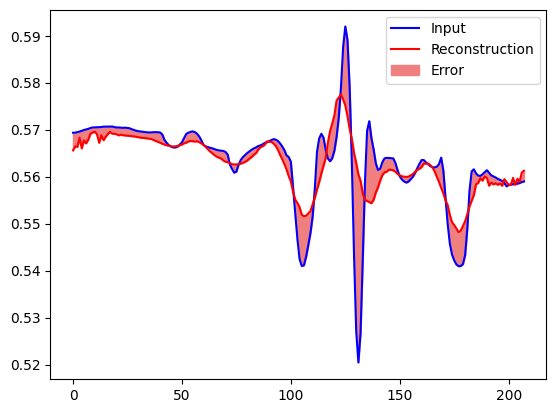

-------------------------
ITEM: 750


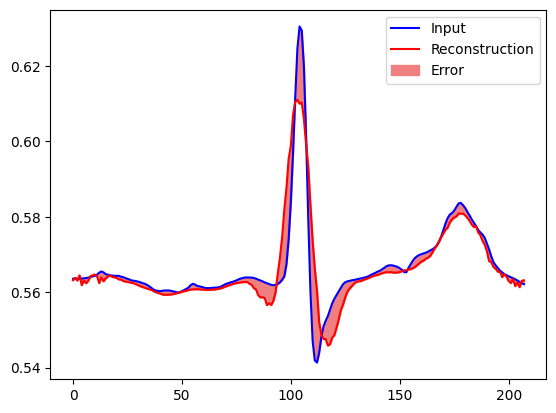

-------------------------
ITEM: 1000


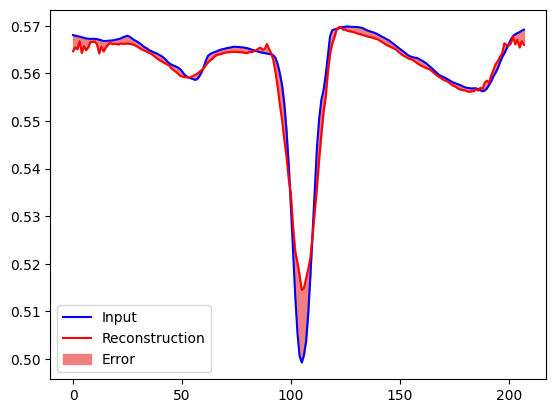

-------------------------
ITEM: 1250


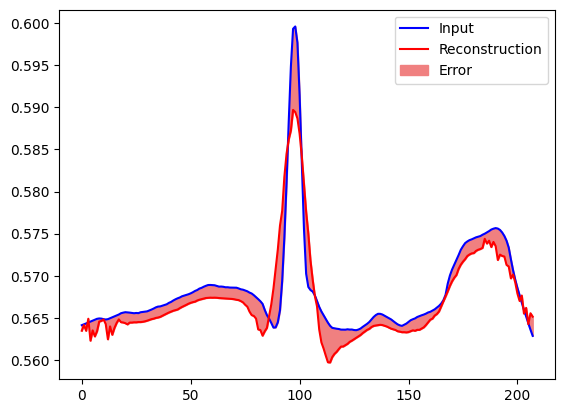

-------------------------
ITEM: 1500


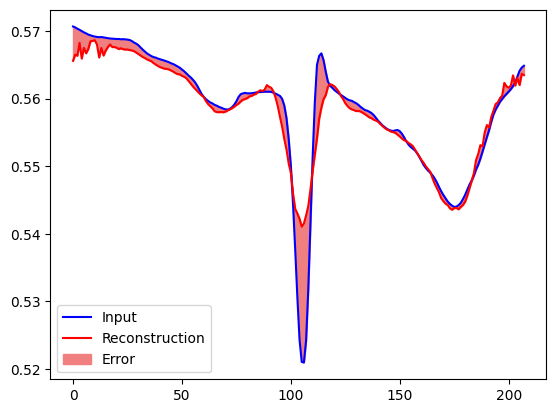

-------------------------
ITEM: 1750


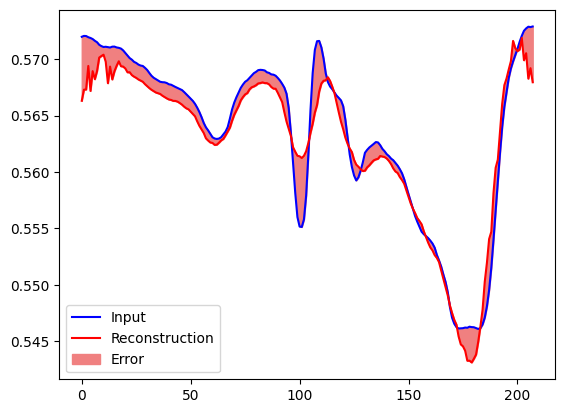

-------------------------
ITEM: 2000


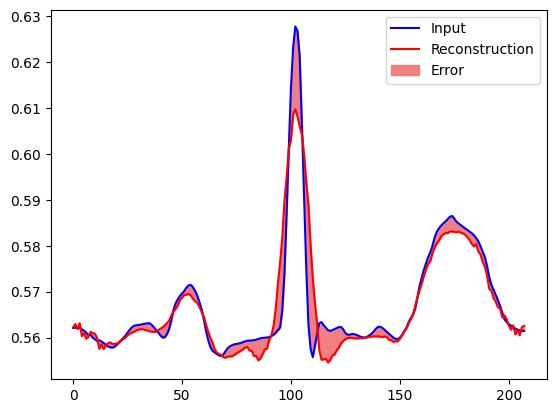

-------------------------
ITEM: 2250


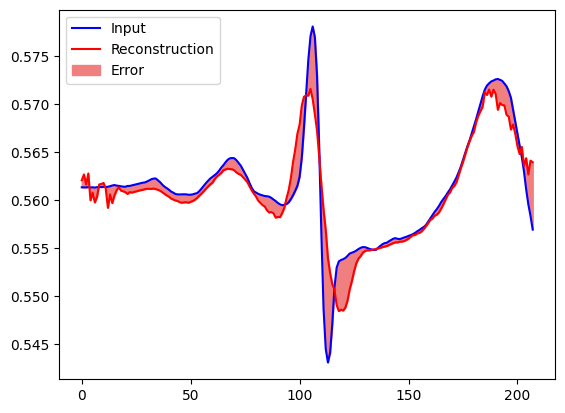

-------------------------
ITEM: 2500


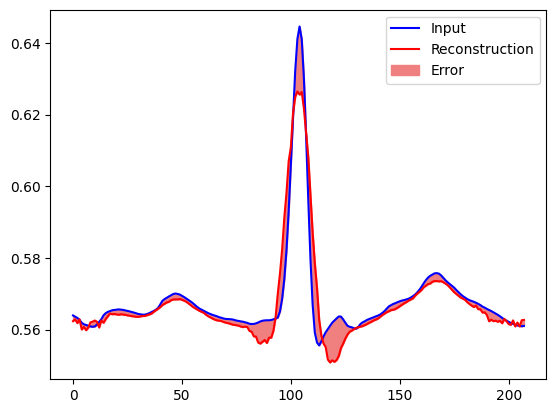

-------------------------
ITEM: 2750


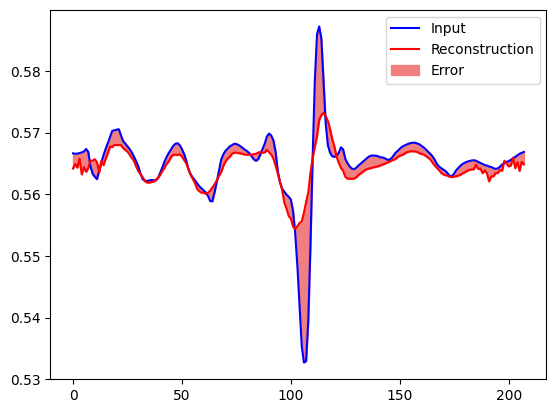

-------------------------
ITEM: 3000


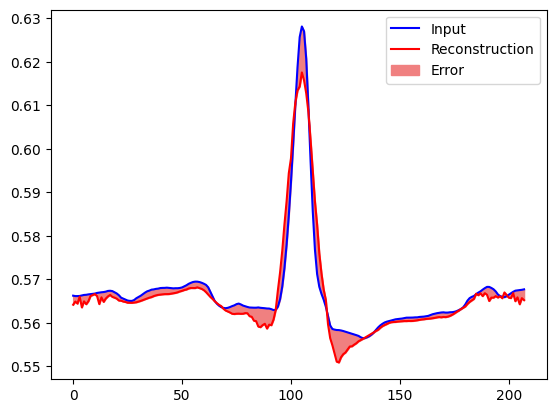

-------------------------
ITEM: 3250


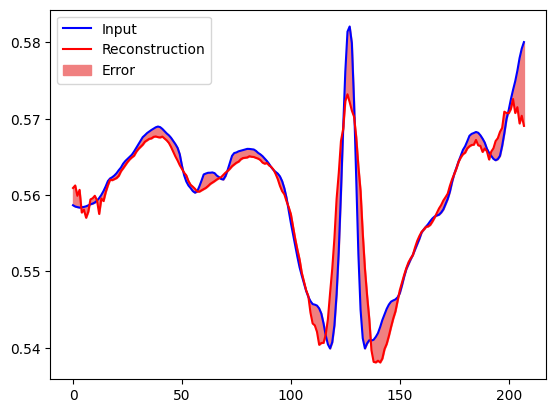

-------------------------
ITEM: 3500


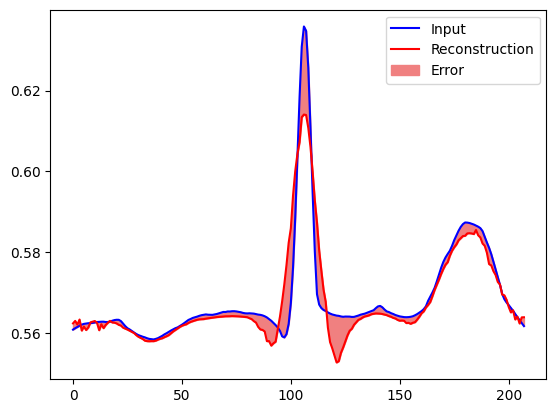

-------------------------
ITEM: 3750


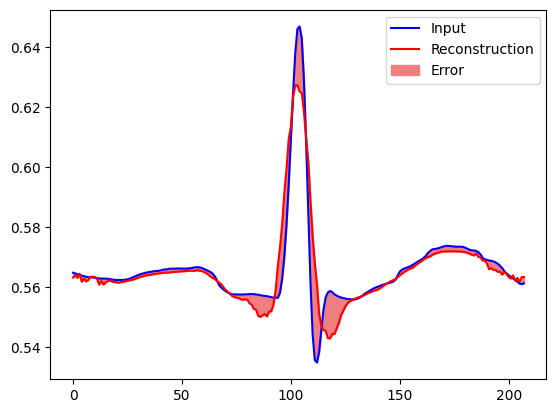

-------------------------
ITEM: 4000


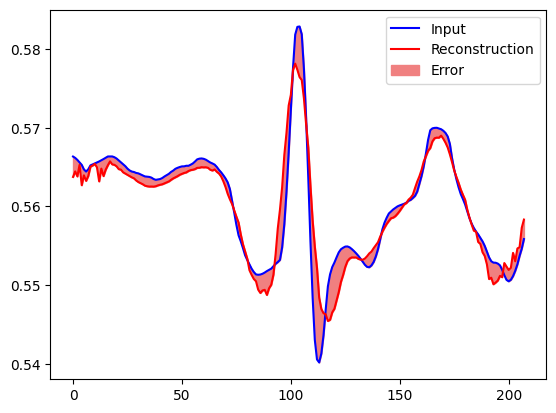

-------------------------
ITEM: 4250


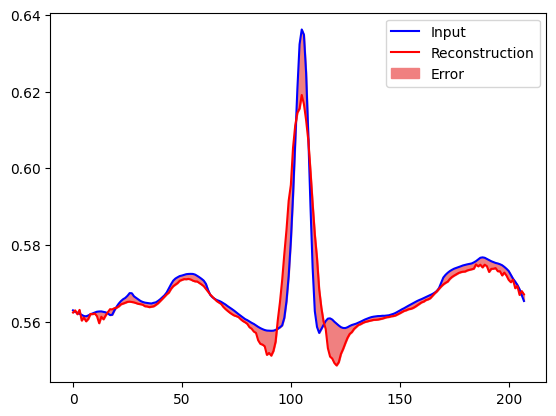

-------------------------
ITEM: 4500


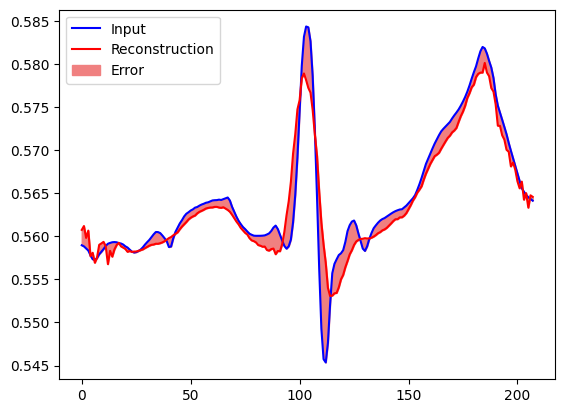

-------------------------
ITEM: 4750


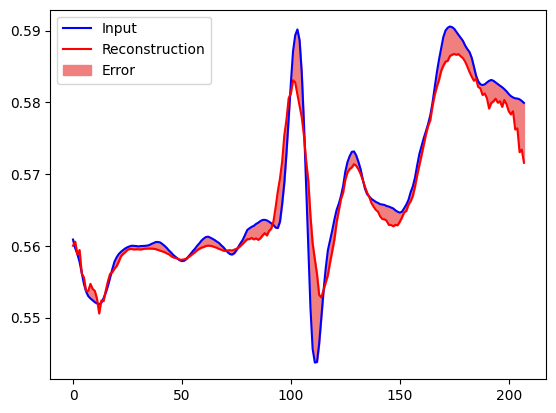

In [188]:
#reconstruction of individual samples

encoded_data = autoencoder.encoder(train_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for i in range(0,5000,250):
    print('-------------------------')
    print("ITEM: " + str(i))

    plt.plot(train_data[i], 'b')
    plt.plot(decoded_data[i], 'r')
    plt.fill_between(np.arange(SAMPLE_LENGTH), decoded_data[i].flatten(), train_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [190]:
#capture inference time for recording
AE_test_start = time.time()
data = autoencoder(test_data)
AE_test_time = time.time() - AE_test_start


In [191]:
print('IF train: ' + str(IF_train_time))
print('IF test: ' + str(IF_test_time))
print('GMM train: ' + str(GMM_train_time))
print('GMM test: ' + str(GMM_test_time))
print('AE train: ' + str(AE_train_time))
print('AE test: ' + str(AE_test_time))

IF train: 5.741283416748047
IF test: 0.7331638336181641
GMM train: 1.682375431060791
GMM test: 0.010002374649047852
AE train: 406.2358524799347
AE test: 7.599698543548584


Accuracy = 0.4886536318508763
Precision = 0.4928246524441028
Recall = 0.7793030088136967


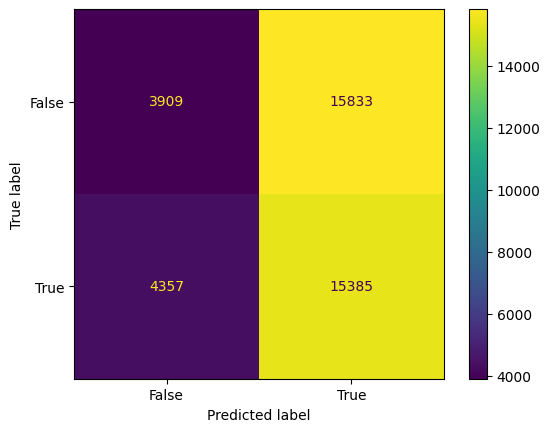

In [144]:
#calculate and print results

def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.binary_crossentropy(reconstructions, data)
    return tf.math.less(loss, threshold)

def NN_mapper(Y):
    if Y == 0:
        return False
    else:
        return True


test_labels_mapped = []
for each in test_labels:
    test_labels_mapped.append(NN_mapper(each))

threshold = np.mean(train_loss) + (np.std(train_loss)*0)
cm = confusion_matrix(test_labels_mapped, predict(autoencoder, test_data, threshold), labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[False,True])

print_stats(predict(autoencoder, test_data, threshold), test_labels)
disp.plot()
plt.show()